In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from string import ascii_lowercase
import requests
import random

from makemore_v3 import Linear, BatchNorm1d, Tanh, Embedding, FlattenConsecutive, Sequential

In [2]:
# get list of words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    ).text.splitlines()
print(f'{len(words)=}')
print(f'{words[:5]=}')

len(words)=32033
words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# integer mappings of characters
chars = ascii_lowercase
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [4]:
# total characters (possible prediction outcomes)
vocab_size = len(itos)
# number of previous characters to consider for prediction
block_size = 8 # increasing block size
# dimensionality of character embedding vectors
n_embed = 10
# number of neurons in the hidden layer
n_hidden = 200

In [5]:
# build dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# use build_dataset for train/val/test splits
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# training, val, and testing dataset sizes
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
torch.manual_seed(42);

In [16]:
# using sequential container
model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # makes last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
    p.requires_grad = True

22097


In [17]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3014
  10000/ 200000: 2.4842
  20000/ 200000: 2.3717
  30000/ 200000: 1.9439
  40000/ 200000: 2.2832
  50000/ 200000: 1.9641
  60000/ 200000: 1.7945
  70000/ 200000: 2.1443
  80000/ 200000: 2.1901
  90000/ 200000: 2.0436
 100000/ 200000: 1.9192
 110000/ 200000: 1.8887
 120000/ 200000: 1.9857
 130000/ 200000: 1.8097
 140000/ 200000: 1.9552
 150000/ 200000: 1.9515
 160000/ 200000: 2.4855
 170000/ 200000: 2.1160
 180000/ 200000: 2.1683
 190000/ 200000: 1.8018


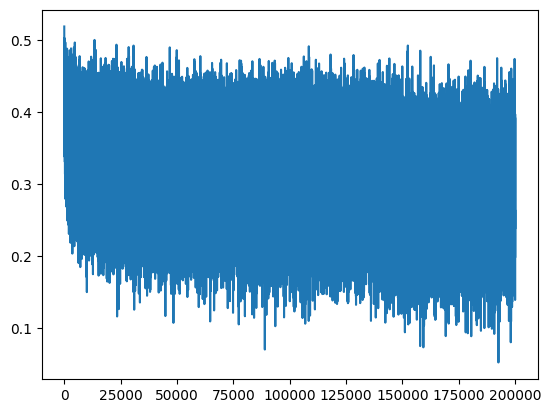

In [18]:
# plot loss over iterations
plt.plot(lossi)

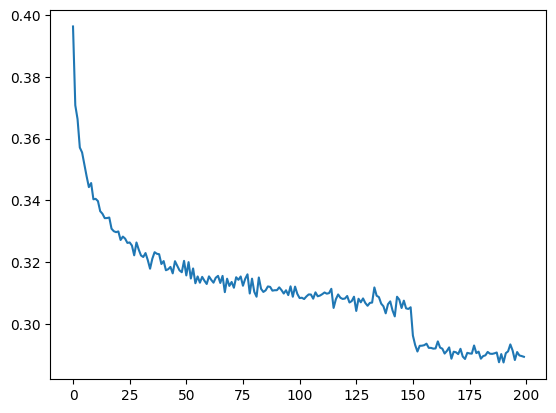

In [19]:
# averaging loss values for better viewing
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [20]:
# evaluation mode
for layer in model.layers:
    layer.training = False

In [21]:
# evaluate loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9219012260437012
val 2.0292062759399414


In [22]:
# sample from model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

niccrelie.
tariell.
layelle.
hirwhi.
jenzar.
yiannah.
yailynn.
aniel.
kaleen.
hartis.
j.
jazza.
cam.
averiaose.
aniyah.
nimiyah.
jarianri.
maudiel.
linn.
lynnon.


This is still only working okay, even with the larger block size. What we need is a better architecture. We're squashing everything into a single hidden layer.

A better structure to try is a 'WaveNet', which slowly combines the larger dimensions into smaller dimensions over a series of layers, or 'waves'.

In [24]:
for i in range(3):
    print(model.layers[i].out.shape)

torch.Size([1, 8, 10])
torch.Size([1, 80])
torch.Size([1, 200])


For a single example above, the structure is (1 example, 8 characters, 10-dimensional embedding per character). We would like to successively combine groups of characters, so the next wave will be: (1 example, 4 groups of bigrams, 20-dimensional bigram).

In [28]:
e = torch.randn(1, 8, 10)
e_wave1 = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
print(e.shape)
print(e_wave1.shape)
e_wave1_view = e.view(1, 4, 20)
print(e_wave1_view.shape)

torch.Size([1, 8, 10])
torch.Size([1, 4, 20])
torch.Size([1, 4, 20])


In [7]:
# using sequential container
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(8),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # makes last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
    p.requires_grad = True

22097


In [8]:
# batch of 4 examples
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0,  0,  0, 20,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0, 11]])


In [9]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


Now let's try multiple layers to successively combine groups of letters.

In [15]:
# combine 2 groupings in every layer
grouping_div = 2
# redefine n_hidden to have about same number of parameters as above, but better performance
n_hidden = 68
# using sequential container
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(grouping_div), Linear(n_embed * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(grouping_div), Linear(n_hidden * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(grouping_div), Linear(n_hidden * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # makes last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
    p.requires_grad = True

22397


In [16]:
# batch of 4 examples
ix = torch.randint(0, Xtr.shape[0], (4, ))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
print(Xb)

torch.Size([4, 8])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 11,  5],
        [ 0,  0,  0, 13,  1,  4,  4, 25]])


In [17]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [18]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2990
  10000/ 200000: 2.0473
  20000/ 200000: 2.2110
  30000/ 200000: 2.1623
  40000/ 200000: 1.8809
  50000/ 200000: 2.2910
  60000/ 200000: 1.9614
  70000/ 200000: 2.3807
  80000/ 200000: 2.1354
  90000/ 200000: 2.2257
 100000/ 200000: 1.8933
 110000/ 200000: 1.8943
 120000/ 200000: 1.8870
 130000/ 200000: 2.3045
 140000/ 200000: 2.3841
 150000/ 200000: 1.7760
 160000/ 200000: 1.8416
 170000/ 200000: 1.8781
 180000/ 200000: 2.1012
 190000/ 200000: 2.0951


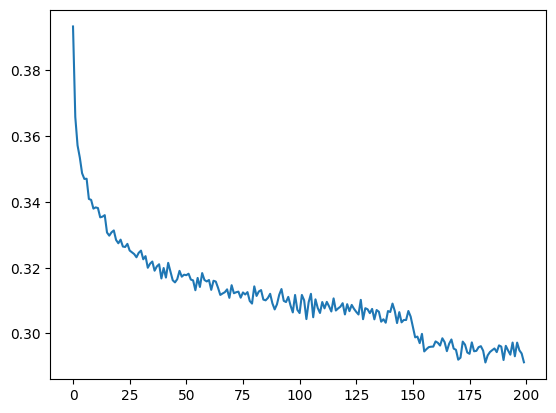

In [19]:
# averaging loss values for better viewing
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [20]:
# evaluation mode
for layer in model.layers:
    layer.training = False

In [21]:
# evaluate loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.942144751548767
val 2.02234148979187


In [22]:
# sample from model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

koden.
marolyn.
ginny.
tyenna.
dayden.
sabra.
nseky.
suelly.
jharlynn.
alechair.
riyisses.
avesen.
kolee.
brylee.
reyden.
lenavi.
zailian.
rivain.
kenlynn.
amayri.


There is a bug in the BatchNorm in how it uses multidimensional tensors to calculate. Checking for 2 or 3 dimensions, and calculating along the mean of those first one or two dimensions, fixes the bug.

In [7]:
# combine 2 groupings in every layer
grouping_div = 2
# redefine n_hidden to have about same number of parameters as above, but better performance
n_hidden = 68
# using sequential container
model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(grouping_div), Linear(n_embed * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(grouping_div), Linear(n_hidden * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(grouping_div), Linear(n_hidden * grouping_div, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter initialization
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # makes last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of total parameters
for p in parameters:
    p.requires_grad = True

22397


In [12]:
# same optimization as last time
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150_000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2346
  10000/ 200000: 2.0399
  20000/ 200000: 2.2273
  30000/ 200000: 2.5516
  40000/ 200000: 2.0444
  50000/ 200000: 2.0812
  60000/ 200000: 1.6634
  70000/ 200000: 1.8523
  80000/ 200000: 2.3734
  90000/ 200000: 2.2750
 100000/ 200000: 1.9335
 110000/ 200000: 1.8839
 120000/ 200000: 1.8106
 130000/ 200000: 1.7873
 140000/ 200000: 1.8556
 150000/ 200000: 2.1317
 160000/ 200000: 2.1896
 170000/ 200000: 1.7874
 180000/ 200000: 2.1897
 190000/ 200000: 2.4972


In [10]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [11]:
# correct shape
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

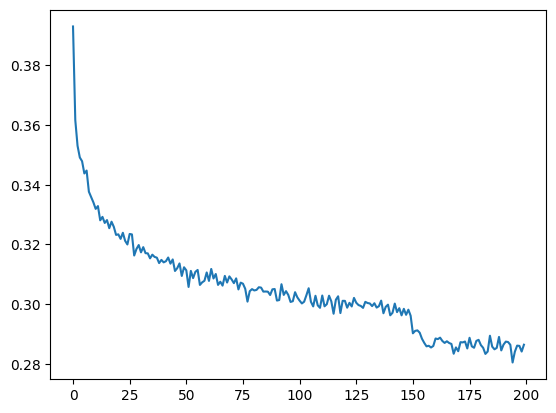

In [13]:
# averaging loss values for better viewing
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [14]:
# evaluation mode
for layer in model.layers:
    layer.training = False

In [15]:
# evaluate loss
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.910833477973938
val 2.0204241275787354


In [16]:
# sample from model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

lynnia.
elexon.
allista.
audlyn.
cadysin.
kimber.
synnabe.
zhry.
jkeer.
shiito.
norvand.
maarith.
brakya.
lawheo.
doneleigh.
reuno.
zacout.
kage.
juvar.
wylmi.
